## Load data

In [3]:
import pandas as pd
from urllib.request import urlopen
from sklearn.preprocessing import LabelEncoder

name_data = urlopen('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names')
lines = [l.decode("utf-8") for l in name_data if ':' in l.decode("utf-8") and '|' not in l.decode("utf-8")]

features = [l.split(':')[0] for l in lines]
label_name = 'income'

cat_features = [l.split(':')[0] for l in lines if 'continuous' not in l]

train_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data',
                       names=features + [label_name])
val_df = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test',
                      names=features + [label_name], skiprows=1)

val_df[label_name] = val_df [label_name].str[:-1]

encoder = LabelEncoder()
encoder.fit(train_df[label_name])
train_df[label_name] = encoder.transform(train_df[label_name])
val_df[label_name] = encoder.transform(val_df[label_name])

## Create Dataset

In [12]:
from mlchecks import Dataset

cat_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 
                'race', 'sex', 'native-country']
train_ds = Dataset(train_df, label=label_name, cat_features=cat_features)
validation_ds = Dataset(val_df, label=label_name, cat_features=cat_features)


## Classification model

In [13]:
from catboost import CatBoostClassifier
clf = CatBoostClassifier(iterations=10, silent=True, cat_features=cat_features)
clf.fit(train_ds.features_columns(), train_ds.label_col())

Segmentperformance

Display performance metric segmented by 2 given features in a heatmap.

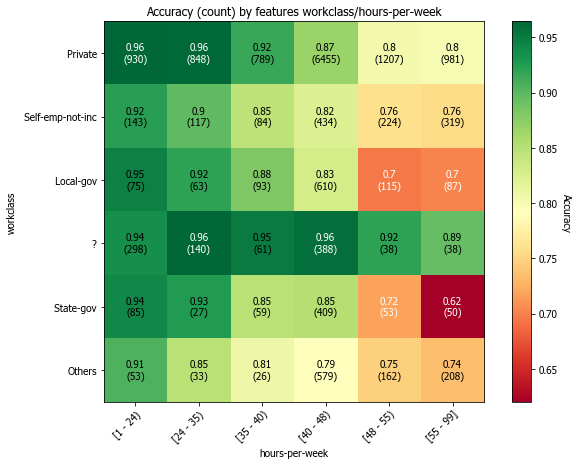

In [14]:
from mlchecks.checks.performance.segment_performance import SegmentPerformance

SegmentPerformance(feature_1='workclass', feature_2='hours-per-week').run(validation_ds, clf)